#  Nonlinearity

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LogisticRegression
import sklearn.datasets

from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing

from sklearn.pipeline import Pipeline

import tensorflow as tf
import itertools

from sklearn.feature_selection import SelectFromModel

import sklearn.svm
import sklearn.inspection


%matplotlib inline
    
def create_row_set(nrows: int, ncols: int, title=None, subtitles=None):
    if subtitles is None: subtitles = list()
        
    fig = plt.figure(constrained_layout=True, figsize=(15,5*nrows))
    if title is not None:
        fig.suptitle(title)
        
    t = []
    axs_row = fig.subfigures(nrows=nrows, ncols=1)
    for row, subfig, subtitle in itertools.zip_longest(range(nrows), axs_row, subtitles):
        axs = subfig.subplots(nrows=1, ncols=ncols)
        if subtitle is not None:
            subfig.suptitle(subtitle)
        t.append([*axs])
    return np.array(t)

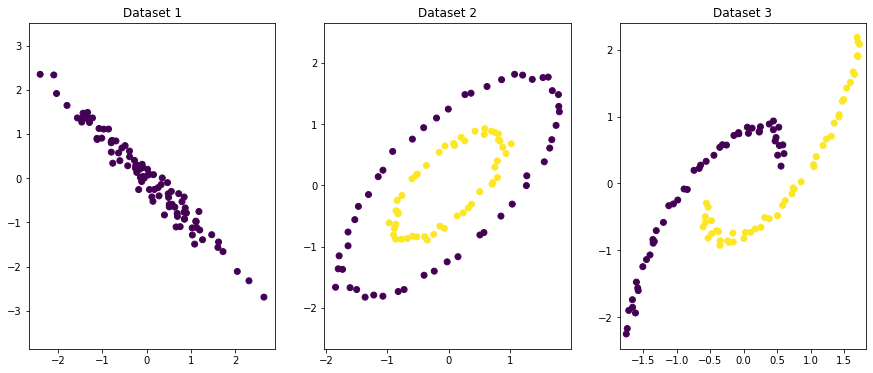

In [2]:
# creates data
np.random.seed(0)
Xs = [
    np.random.randn(100, 2) @ np.array([[1, -3],[-1, 2]]),
    sklearn.datasets.make_circles(factor=0.5, noise=0.03, shuffle=False)[0] @ np.array([[0, 1], [1, 1]]) ,
    sklearn.datasets.make_moons(noise=0.03, shuffle=False)[0] @ np.array([[1, 1], [0, 1]]),
]
Cs = [
    np.zeros(100),
    sklearn.datasets.make_circles(shuffle=False)[1],
    sklearn.datasets.make_moons(shuffle=False)[1],
]

Xs = [ sklearn.preprocessing.StandardScaler().fit_transform(X) for X in Xs]


def transform_and_draw(axs, transformation):
    for i,(X, C) in enumerate(zip(Xs, Cs)):
        X = transformation.fit_transform(X)
        axs[i].axis('equal')
        axs[i].scatter(*X.T, c=C)
        axs[i].set_title(f'Dataset {i+1}')
        

fig, axs = plt.subplots(1, len(Xs), figsize=(15,6))
transform_and_draw(axs, StandardScaler())

## PCA

Linear transformation of the data into a new coordinate system where the basis gradually decreases described variation in the original dataset.

- Dimensionality reduction
- Dataset exploration

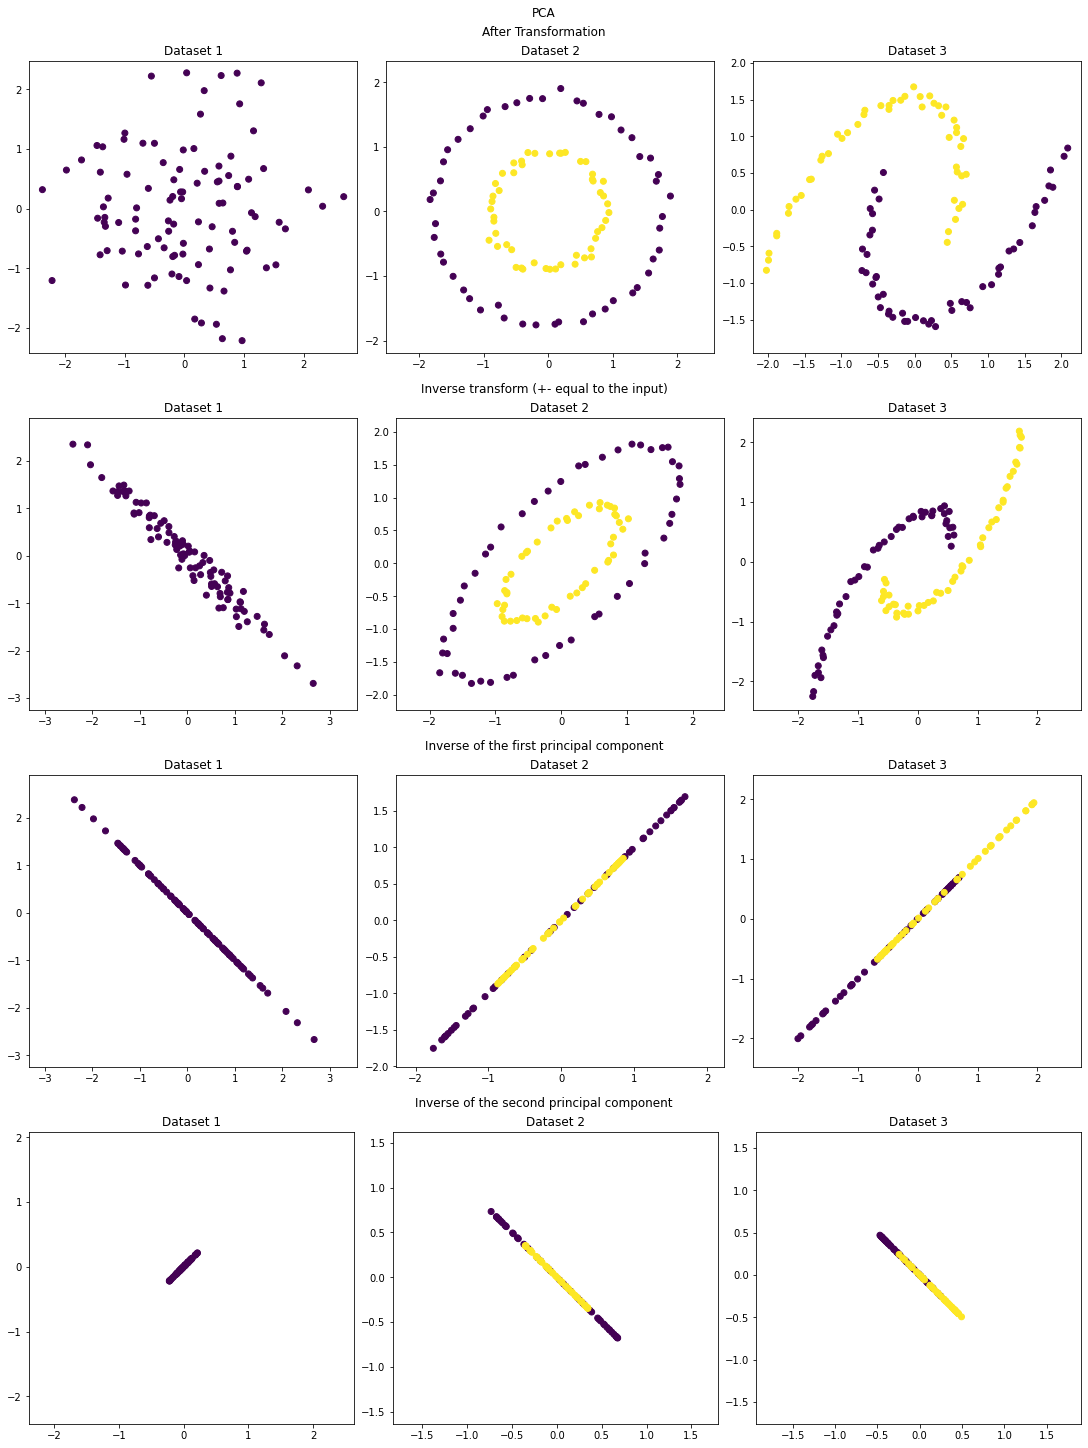

In [3]:
class PCA_inverse(PCA):
    def __init__(self, zero=None):
        super().__init__(n_components=2)
        self.zero = zero
        
    def fit_transform(self, X):
        Xi = super().fit_transform(X)
        if self.zero is not None:
            Xi[:, self.zero] = 0.
        return super().inverse_transform(Xi)


axs = create_row_set(4,3,title='PCA', subtitles=[
    'After Transformation', 
    'Inverse transform (+- equal to the input)', 
    'Inverse of the first principal component',
    'Inverse of the second principal component',
])

transform_and_draw(axs[0], PCA(n_components=2, whiten=True))
transform_and_draw(axs[1], PCA_inverse())
transform_and_draw(axs[2], PCA_inverse(zero=1))
transform_and_draw(axs[3], PCA_inverse(zero=0))
    
for i, ax in enumerate(axs[1]):
    for y in range(2,4):
        axs[y][i].set_xlim(ax.get_xlim())
        axs[y][i].set_ylim(ax.get_ylim())

### Explained Variance Ratio
- The percentage of variance that is attributed by each of the selected eigenvectors.
- Can be used to ad-hoc feature selection.

In [4]:
PCA().fit(Xs[0]).explained_variance_ratio_

array([0.9907545, 0.0092455])

### Digits Example
- high dimensionality
- low information density

Original Data


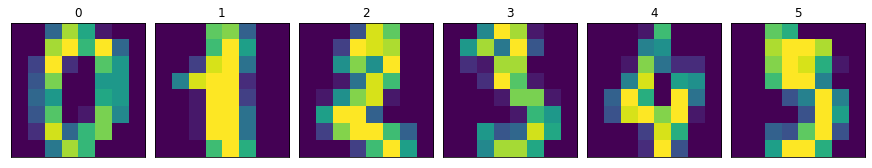

Full and Random Selection after PCA (10D)


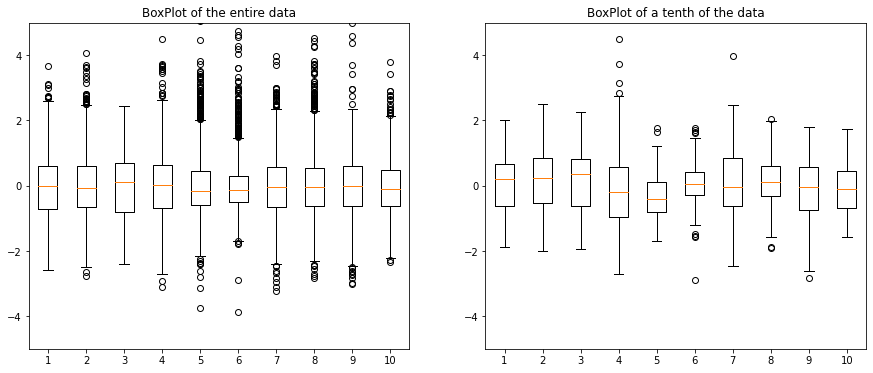

Only one digit after PCA transformation (10D)


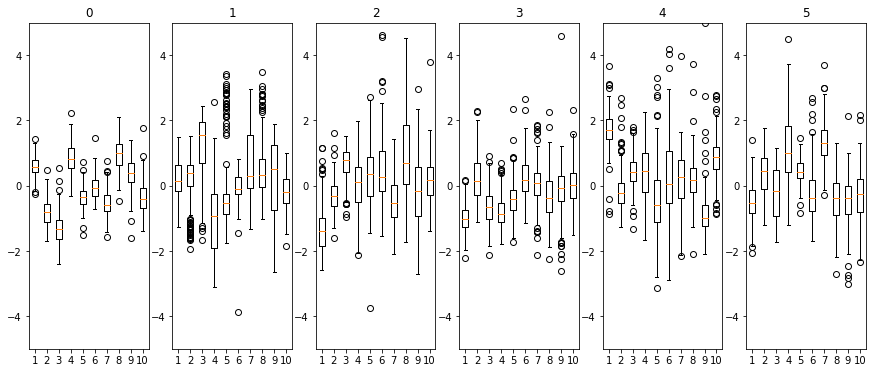

In [5]:
X, Y = sklearn.datasets.load_digits(return_X_y = True)

print('Original Data')
fig, axs = plt.subplots(1,6, figsize=(12,6), constrained_layout=True)

for i in range(6):
    axs[i].imshow(X[i].reshape(8,8))
    axs[i].set_title(str(i))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

print('Full and Random Selection after PCA (10D)')
X = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
]).fit_transform(X)

fig, axs = plt.subplots(1,2, figsize=(15,6))
scaler = StandardScaler().fit(X)

for i, dX in enumerate([X, X[:len(X)//10]]):
    axs[i].boxplot(scaler.transform(dX))
    axs[i].set_ylim(-5, 5)
    
axs[0].set_title('BoxPlot of the entire data')
axs[1].set_title('BoxPlot of a tenth of the data')
plt.show()

print('Only one digit after PCA transformation (10D)')
fig, axs = plt.subplots(1,6, figsize=(15,6))
for i in range(6):
    t = scaler.transform(X[Y == i])
    axs[i].boxplot(t)
    axs[i].set_ylim(-5, 5)
    axs[i].set_title(str(i))
plt.show()

In [6]:
X, Y = sklearn.datasets.load_digits(return_X_y = True)

class Select:
    ''' selects first 10 features '''
    def fit(self, X, Y):
        return self
    def transform(self, X):
        return X[:, :10]

pipeline = Pipeline([
    ('select', Select()),
    ('cls', LogisticRegression(max_iter=10000))
]).fit(X, Y)

a = sklearn.metrics.accuracy_score(pipeline.predict(X), Y )
print('Selects first 10 features: ')
print(f'Accuracy: {a}')


pipeline = Pipeline([
    ('select', SelectFromModel(estimator=LogisticRegression(max_iter=10000), max_features=10)),
    ('cls', LogisticRegression(max_iter=10000))
]).fit(X, Y)

a = sklearn.metrics.accuracy_score(pipeline.predict(X), Y )
print('\nSelects best 10 features: ')
print(f'Accuracy: {a}')

pipeline = Pipeline([
    ('pca', PCA(n_components=10)),
    ('cls', LogisticRegression(max_iter=10000))
]).fit(X, Y)

a = sklearn.metrics.accuracy_score(pipeline.predict(X), Y )
print('\nSelects 10 biggest eigenvectors: ')
print(f'Accuracy: {a}')



Selects first 10 features: 
Accuracy: 0.44741235392320533

Selects best 10 features: 
Accuracy: 0.8664440734557596

Selects 10 biggest eigenvectors: 
Accuracy: 0.9532554257095158


[(1, 0.36672231496939345), (4, 0.8130217028380634), (7, 0.9065108514190318), (10, 0.9532554257095158), (13, 0.9627156371730662), (16, 0.9738452977184195), (19, 0.991652754590985), (22, 0.996661101836394), (25, 0.9988870339454646), (28, 1.0)]


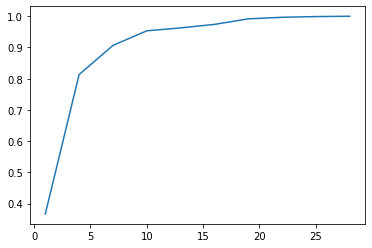

In [7]:
components = np.arange(1, 30, 3)
acc = []

X_pca = PCA(n_components=50).fit_transform(X)

for n_components in components:
    lr = LogisticRegression(max_iter=10000).fit(X_pca[:,:n_components], Y)
    acc.append(sklearn.metrics.accuracy_score(lr.predict(X_pca[:, :n_components]), Y))
    
plt.plot(components, acc)

print(list(zip(components, acc)))
    

## Transformation of the Feature Space

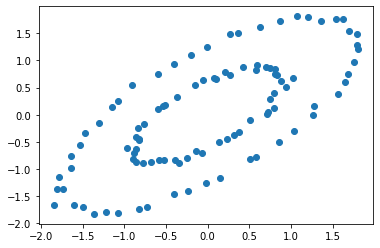

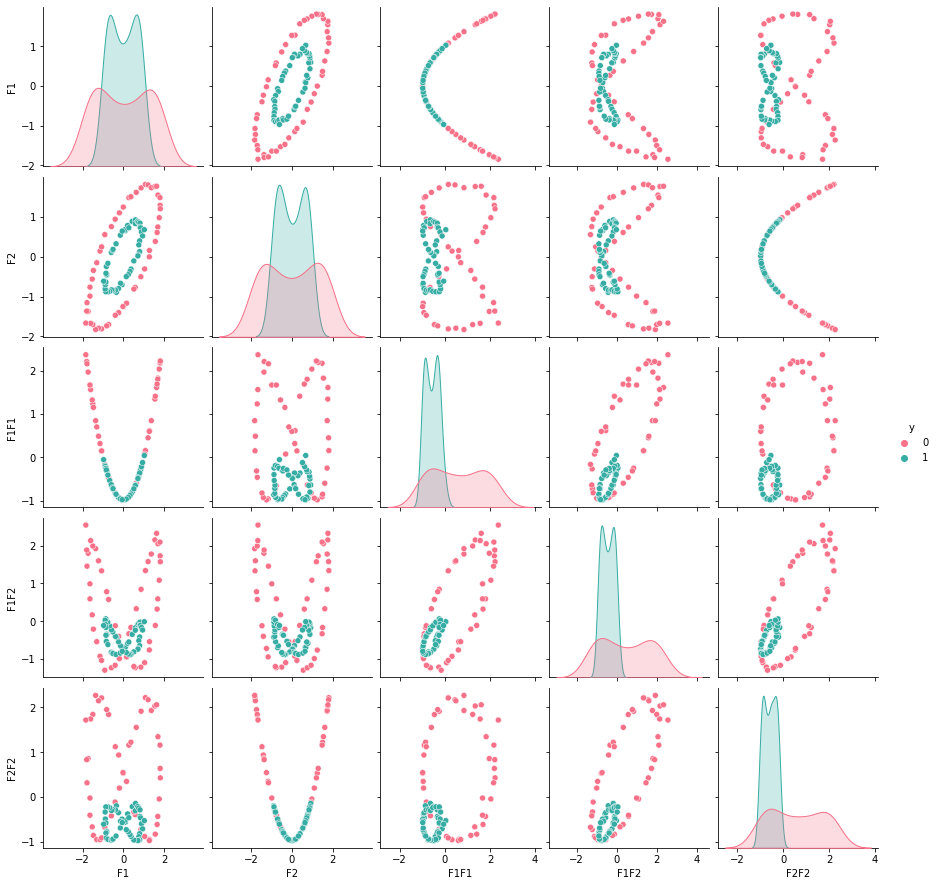

In [8]:
import seaborn as sb
import pandas as pd

PP = Pipeline([
    ('polynomial_features', sklearn.preprocessing.PolynomialFeatures(2, include_bias=False)),
    ('normalize input', StandardScaler()),
])

for dataset in [1]:
    X, C = Xs[dataset], Cs[dataset]
    
    plt.figure()
    plt.scatter(*X.T, label='Original Feature Space')
    
    X = PP.fit_transform(X)
    X = pd.DataFrame(dict(F1=X[:, 0], F2=X[:, 1], F1F1=X[:, 2], F1F2=X[:, 3], F2F2=X[:, 4], y=C))
    sb.pairplot(data=X, hue = 'y', diag_kind = "kde",kind = "scatter", palette = "husl")

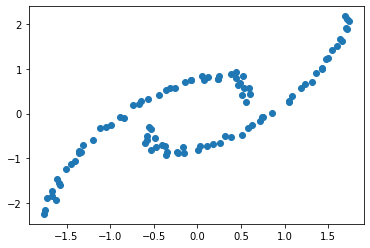

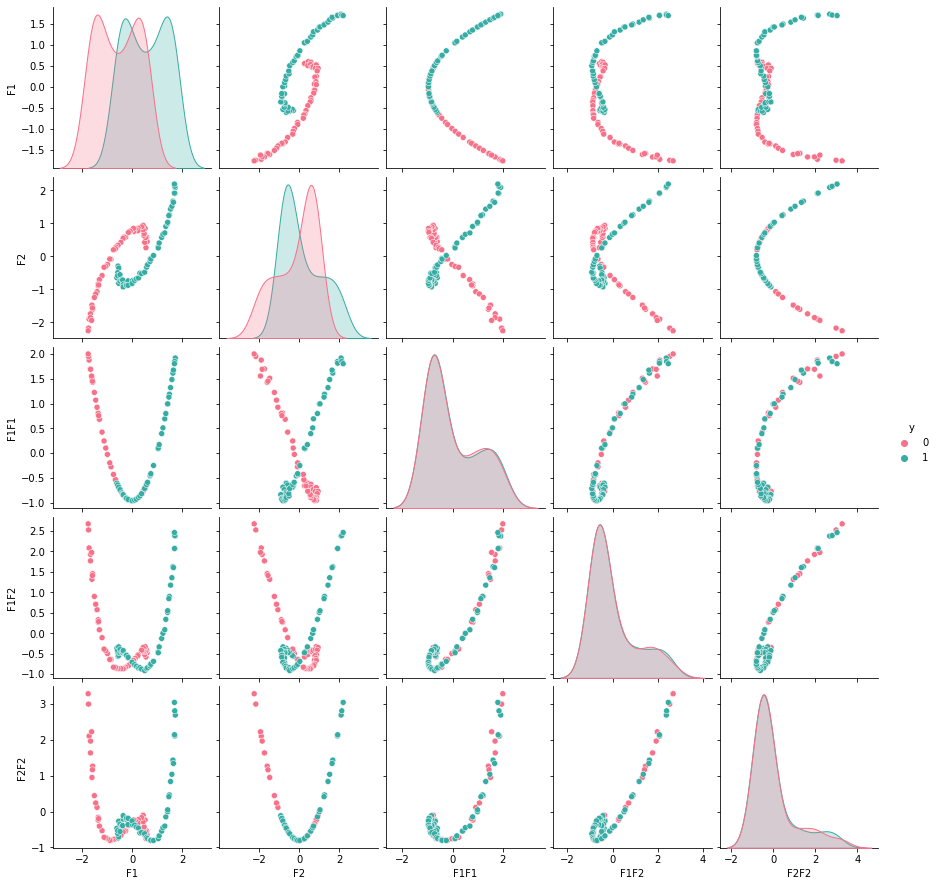

In [9]:
for dataset in [2]:
    X, C = Xs[dataset], Cs[dataset]
    
    plt.figure()
    plt.scatter(*X.T)
    
    X = PP.fit_transform(X)
    X = pd.DataFrame(dict(F1=X[:, 0], F2=X[:, 1], F1F1=X[:, 2], F1F2=X[:, 3], F2F2=X[:, 4], y=C))
    sb.pairplot(data=X, hue = 'y', diag_kind = "kde",kind = "scatter", palette = "husl")

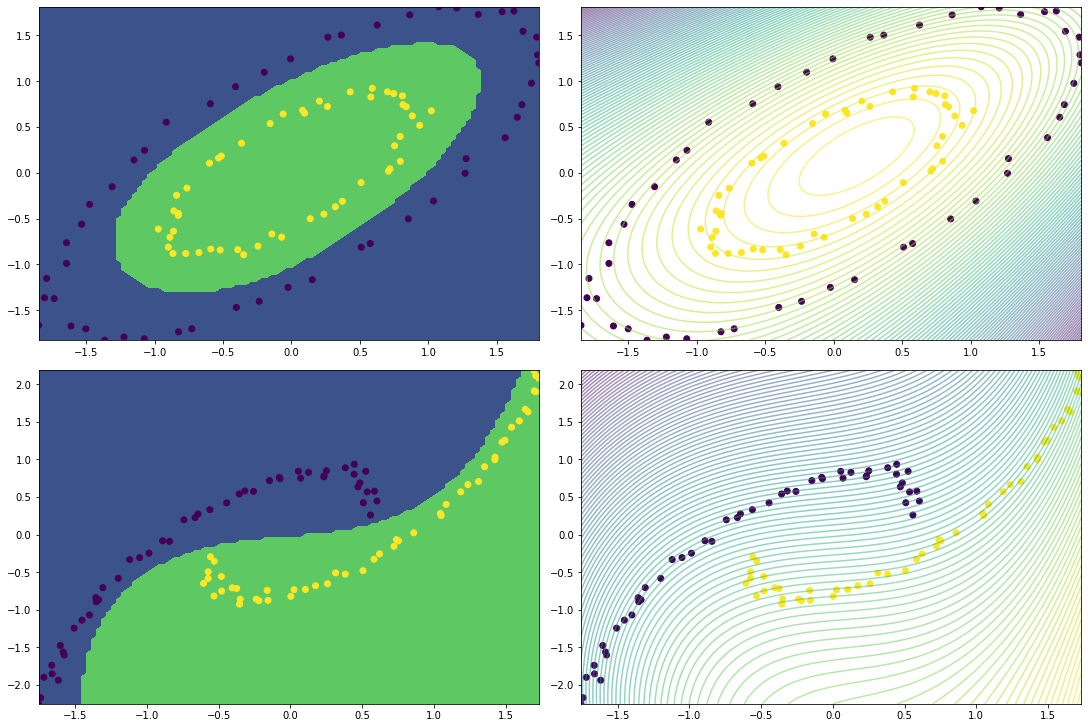

In [10]:
P_pol = Pipeline([
    ('minmax', sklearn.preprocessing.MinMaxScaler()),
    ('polynomial_features', sklearn.preprocessing.PolynomialFeatures(3, include_bias=False)),
    ('classification', LogisticRegression(C=1000000))
])

axs = create_row_set(2, 2, title=None, subtitles=None)

for dataset, ax in zip([1,2], axs):
    X, C = Xs[dataset], Cs[dataset]
    
    P_pol.fit(X, C)
    
    Xspace = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    Yspace = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    
    XX, YY = np.meshgrid(Xspace, Yspace)
    mesh = np.vstack([XX.reshape(-1), YY.reshape(-1)]).T
    
    r_mesh_decision = P_pol.predict(mesh).reshape(100,100)
    r_mesh_value    =  P_pol.decision_function(mesh).reshape(100,100)
    
    ax[0].contourf(Xspace, Yspace, r_mesh_decision, levels=1)
    ax[1].contour(Xspace, Yspace, r_mesh_value, levels=100, alpha=0.5)
    
    ax[0].scatter(X[:,0], X[:, 1], c=C)
    ax[1].scatter(X[:,0], X[:, 1], c=C)

## Kernel Trick

### Feature space transformation
Functions that maps usually low-dimensional feature space into higher-dimensional feature space.
$$
\mathbf{x} \dots \text{input space} \\
\mathbf{y} \dots \text{expanded input space} \\
\mathbf{w} \dots \text{weights of a classification model} \\
\\
\varphi(x) = y 
$$

Instead of using bare $\mathbf{x}$ in the linear regression model
$$
    f(\mathbf{x}) = \left<\mathbf{x}, \mathbf{w}\right> = \sum^D_{i=1} x_i w_i,
$$
the inner product $\left<,\right>$ uses expanded feature space.
$$
    f(\mathbf{x}) = \left<\varphi(\mathbf{x}), \mathbf{w}\right> = \sum^{D_\varphi}_{i=1} \varphi(x)_i w_i,
$$


### Kernel Trick
The space required to save and process feature space can be huge.

Let's consider the MNIST database as an example. The MNIST have 60000 training samples with 784 features by 4 Bytes each.
It is roughly **180 MB** of uncompressed memory.
If the pure quadratic kernel ($\varphi(x) = [x, x^2]$) is used, the dataset is 360 MB, which is reasonable. On the other hand, full polynomial feature space of second order gives **52 TB**.


Kernel trick avoids this problem by not explicitly saving the resulting feature space but instead defining suitable kernel function that behaves like the dot product of the expanded feature space:
$$
K(a, b) = \left<\varphi(a), \varphi(b)\right>
$$

Interestengly, the $\varphi(x)$ for specific kernel function can be unexpressible.

**Kernel is a function that calculates dot product in the image of some mapping.** The mapping is freqentlly implicit -- you dont need to calculalte it at all, but sometimes the explicit mapping cannot be obtained at all.

### Example - polynomial kernel

In 3d quadratic case the features a,b,c are mapped (up to the constant) into
$\varphi([a,b,c]) = [a, b, c, aa, bb, cc, ab, ac, bc]$. 
In general, the $\varphi(x)$ is proportional to $x_1^{j_1} x_2^{j_2} \dots x_n^{j_n}$, $n = \begin{pmatrix}\text{dim} + \text{degree} \\ \text{degree} \end{pmatrix}$

$$
K_d(x,z) = (x^\top z + c)^d
$$


### Example of kernel without explicit mapping - RBF kernel
$$
K(x,z) = \exp\left( - \frac{\lVert x - z\rVert^2}{2 \sigma^2}  \right)
$$
where $\sigma \in \mathcal{R}$, $\lVert \cdot\rVert$ is Euclidean distance.

The mapping maps every vector to the infinity dimensional space.


$$
\varphi(\mathbf{x})
=
\exp\left(-\frac{1}{2}\|\mathbf{x}\|^2\right)
\left(a^{(0)}_{l_0},a^{(1)}_1,\dots,a^{(1)}_{l_1},\dots,a^{(j)}_{1},\dots,a^{(j)}_{l_j},\dots \right )
$$
where $l_j=\tbinom {k+j-1}{j}$,
$$
a^{(j)}_{l}=\frac{x_1^{n_1}\cdots x_k^{n_k} }{\sqrt{n_1! \cdots n_k! }} \quad|\quad n_1+n_2+\dots+n_k = j \wedge 1\leq l\leq l_j 
$$


Source: https://en.wikipedia.org/wiki/Radial_basis_function_kernel

## Kernel PCA

(1000, 2)


Text(0.5, 1.0, 'Transformed Feature Space')

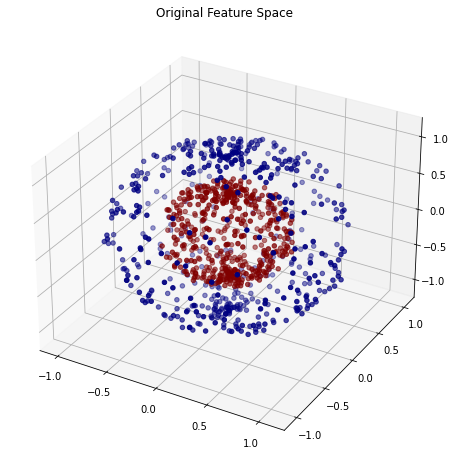

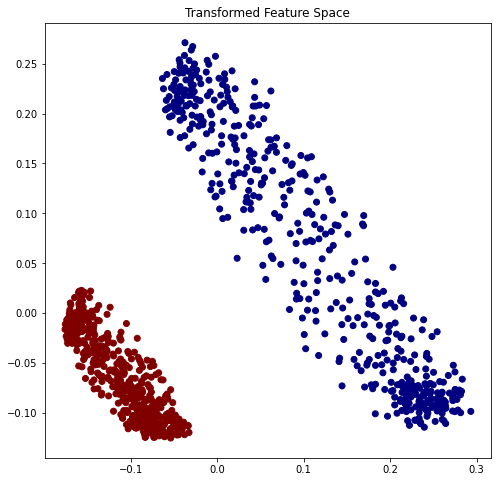

In [11]:
N = 1000

np.random.seed(0)
t1 = np.random.rand(N)* 2*np.pi
t2 = np.random.rand(N)* np.pi

r = np.hstack([
        np.random.rand(N//2)*0.1 + 1.0,
        np.random.rand(N//2)*0.1 + 0.5
])
c = np.hstack([ np.zeros(N//2), np.ones(N//2) ])

sample = np.vstack([np.cos(t1) * np.sin(t2), np.sin(t1) * np.sin(t2), np.cos(t2)]).T \
    * r.reshape(-1, 1)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(*sample.T, c=c, cmap='jet')
ax.set_title('Original Feature Space')


transformed_samples = KernelPCA(kernel='rbf').fit_transform(sample)
transformed_samples = transformed_samples[:, 3:5]
print(transformed_samples.shape)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.scatter(*transformed_samples.T, c=c, cmap='jet')
ax.set_title('Transformed Feature Space')

# Support Vector Machines (SVMs)

- Linear classifier (without kernel function)

## Hard Margin
$$
\begin{align}
&\underset{\mathbf{w},\;b}{\operatorname{minimize}} && \|\mathbf{w}\|_2^2\\
&\text{subject to} && y_i(\mathbf{w}^\top \mathbf{x}_i - b) \geq 1 \quad \forall i \in \{1,\dots,n\}
\end{align}
$$
where $\mathbf{w}$ is weight vector, $b$ is bias, $x_i$ is a training sample $i$, $y_i \in \{-1, 1\}$ is the class of the sample $i$

## Soft margin (Slack variables)
$$
\begin{align}
&\underset{\mathbf{w},\;b,\;\mathbf{\zeta}}{\operatorname{minimize}} &&\|\mathbf{w}\|_2^2 + C\sum_{i=1}^n \zeta_i\\
&\text{subject to} && y_i(\mathbf{w}^\top \mathbf{x}_i - b) \geq 1 - \zeta_i, \quad \zeta_i \geq 0 \quad \forall i\in \{1,\dots,n\}
\end{align}
$$

$\zeta_i \ge 0$ is the slack variable for the $i$-th sample, $C$ is the cost of the margin.
When the $C$ is high, soft margin SVM is equivalent to hard margin.

Source: https://en.wikipedia.org/wiki/Support_vector_machine

In [12]:
X, y = sklearn.datasets.make_blobs(n_samples=40, centers=2, random_state=0)

def draw_SVM_result(ax, svm):
    decision_function = svm.decision_function(X)
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]
    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    sklearn.inspection.DecisionBoundaryDisplay.from_estimator(
        svm, X, ax=ax,
        grid_resolution=100,
        plot_method="contour",
        colors="k",
        alpha=0.5,
        levels=[-1, 0, 1],
        linestyles=["--", "-", "--"],
    )
    ax.scatter(*support_vectors.T,
        s=100, facecolors="none", edgecolors="k",
    )

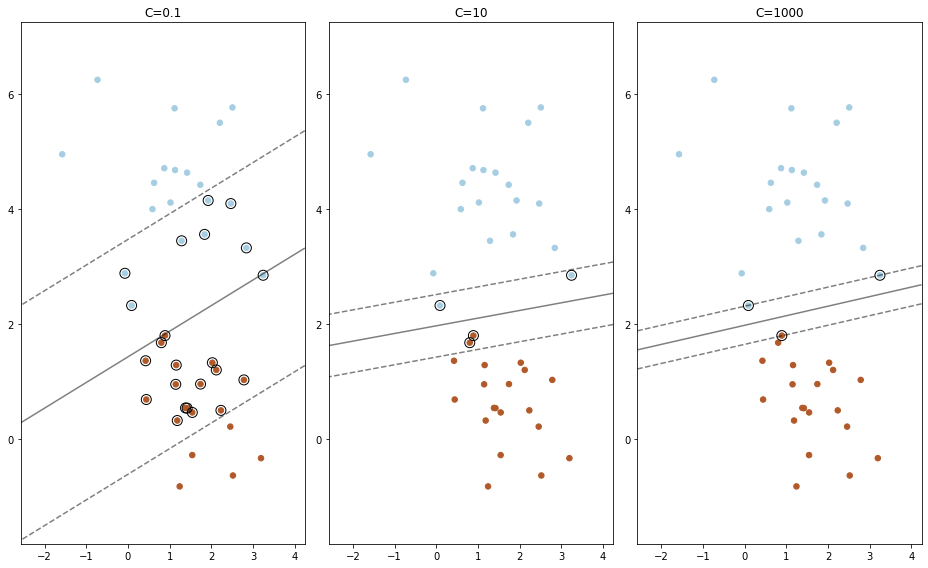

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(13,8), tight_layout=True)

for i, (C, ax) in enumerate(zip([0.1, 10, 1000], axs)):
    clf = sklearn.svm.LinearSVC(C=C, random_state=0, max_iter=2000).fit(X, y)
    
    # draw
    draw_SVM_result(ax, clf)
    ax.set_title("C=" + str(C))
    
plt.show()

C = 1000 results in the same solution as hard margin SVM.

## Kernel Trick

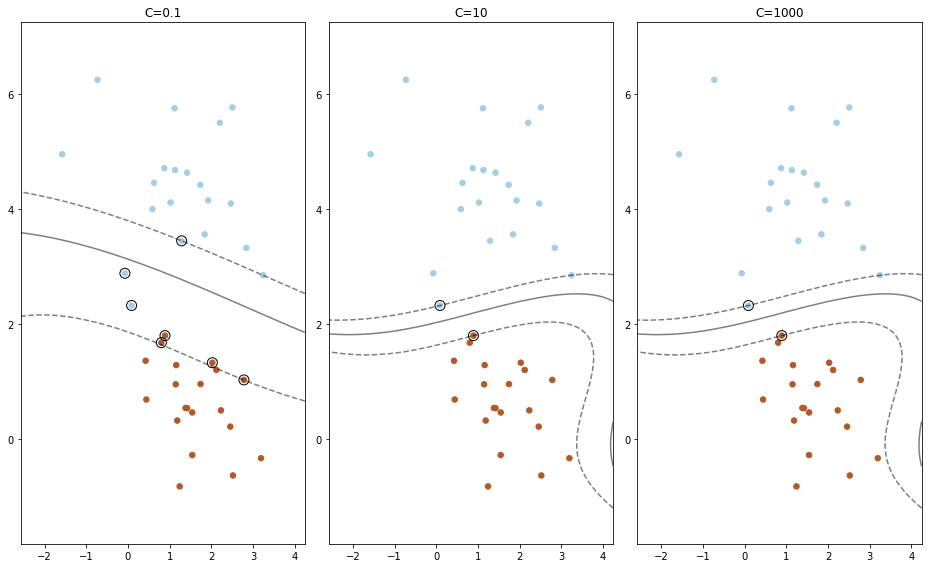

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(13,8), tight_layout=True)

for i, (C, ax) in enumerate(zip([0.1, 10, 1000], axs)):
    clf = sklearn.svm.SVC(C=C, kernel='poly', random_state=0, max_iter=2000).fit(X, y)
    
    # draw
    draw_SVM_result(ax, clf)
    ax.set_title("C=" + str(C))
    
plt.show()

# Task 1 - Non-standard Kernel Function [1b]
Modify the template to show results of SVM with laplacian kernel.

Help: sklern.metrics

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(13,8), tight_layout=True)

for i, (C, ax) in enumerate(zip([0.1, 10, 1000], axs)):
    model = sklearn.svm.SVC(C=C, 
            kernel= ???, # TODO
            random_state=0, 
            max_iter=2000).fit(X, y)
    
    # draw
    draw_SVM_result(ax, model)
    ax.set_title("C=" + str(C))

SyntaxError: invalid syntax (471197190.py, line 5)

# Task 2 - Parameter Search [1b]
- Optimize parameters of the SVM (sklearn.svm.SVC()) classifier bellow. 
- Use sklearn.model_selection.GridSearchCV and provided param_grid.

How many combinations of parameters does the GridSearchCV consider?

In [ ]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

# todo fill Grid
selection = ??? # TODO
selection.fit(X,y)
    
print('Best:')
print(selection.best_estimator_)

fig, ax = plt.subplots(1, 1, figsize=(8,8), tight_layout=True)
draw_SVM_result(ax, selection.best_estimator_)

# Task 3 [1b]
Make suitable transformation of feature space (X) that enables the LogisticRegression to obtain 100% accuracy.

Help: 
- You can use any information except specific state of the random number generator.
- np.linarg.inv ?
- The solution may look like this:
<table><tr>
<td> <img src="sol1.png" alt="Drawing" style="width: 90%;"/> </td>
<td> <img src="sol2.png" alt="Drawing" style="width: 90%;"/> </td>
</tr></table>

In [ ]:
# Dataset Generation (any change of the code in here is forbidden)
N0, N = 100, 1000
np.random.seed(0)

X = np.concatenate([ (np.arange(N) // N0).reshape(-1, 1), np.random.randn(N,1), ], axis=1)
X[:,1] += X[:,0] % 2 * 2 - 1
X[:,0] += np.random.randn(N)*0.1

# rotation
a = np.pi / 4.0
H = np.array([[np.cos(a), -np.sin(a)],[np.sin(a), np.cos(a)]])
X = X @ H

Y = np.arange(N) // N0 % 2

X, Y = sklearn.utils.shuffle(X, Y)

# display the dataset
#fig, ax = plt.subplots(1, 1, figsize=(8,8), tight_layout=True)
#ax.scatter(*X.T, c=Y, cmap='jet')

In [ ]:
class Transformation:
    def fit(self, X, Y):
        # DO NOT ADD ANYTHING HERE
        return self
    
    def transform(self, X):
        # CHANGE THIS METHOD
        return X
        
model = Pipeline([
    ('transformation', Transformation()),
    ('classifier', LogisticRegression())
]).fit(X, Y)


# display
fig, ax = plt.subplots(1, 1, figsize=(8,8), tight_layout=True)

sklearn.inspection.DecisionBoundaryDisplay.from_estimator(
    model, X, ax=ax, grid_resolution=100,
    plot_method="contourf", cmap='jet', alpha=0.5, levels=1,
)

ax.scatter(*X.T, c=Y, cmap='jet')

acc = sklearn.metrics.accuracy_score(Y, model.predict(X))
print(f'Accuracy: {acc:.3}')

# TASK 4 - Kernel PCA [1b]
- Try to solve the same problem using KernelPCA
- Consider only RBF kernel

Help:
    Try to change the gamma parameter.

In [ ]:
transformation = ??? # TODO

model = Pipeline([
    ('transformation', transformation),
    ('classifier', LogisticRegression())
]).fit(X, Y)


# display
fig, ax = plt.subplots(1, 1, figsize=(8,8), tight_layout=True)

sklearn.inspection.DecisionBoundaryDisplay.from_estimator(
    model, X, ax=ax, grid_resolution=100,
    plot_method="contourf", cmap='jet', alpha=0.5, levels=1,
)

ax.scatter(*X.T, c=Y, cmap='jet')

acc = sklearn.metrics.accuracy_score(Y, model.predict(X))
print(f'Accuracy: {acc:.3}')